In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "\\datasets\\empire_mimikatz_logonpasswords_2020-08-07103224.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess_labelEncoder(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    le = preprocessing.LabelEncoder()
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))
        le.fit(df[column])
        df[column] = le.transform(df[column])
            
    return df

# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data
    

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# # for debugging only
# count_nan(df)
# count_nan(new_data)

In [3]:
features = ["Channel", "EventID", "ObjectName", "SubjectUserName", "TargetImage", "CallTrace", "ImageLoaded", "@timestamp", "ProcessGuid", "SourceProcessGUID"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(6026, 10)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [4]:
from sdv.tabular import CTGAN

model = CTGAN(cuda=True)
model.fit(df)

# save and reuse the model
model.save('LSASSMemoryReadAccess.pkl')

# model = CTGAN.load(r'models\\LSASSMemoryReadAccess.pkl')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ly\AppData\Local\Temp/ipykernel_10408/4117382650.py", line 4, in <module>
    model.fit(df)
  File "C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sdv\tabular\base.py", line 149, in fit
    self._fit(transformed)
  File "C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\sdv\tabular\ctgan.py", line 59, in _fit
    discrete_columns=categoricals
  File "C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\ctgan\synthesizers\base.py", line 50, in wrapper
    return function(self, *args, **kwargs)
  File "C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\ctgan\synthesizers\ctgan.py", line 386, in fit
    loss_d.backward()
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\_tensor.py", line 489, in backward
    self, gradient, r

TypeError: object of type 'NoneType' has no len()

In [21]:
new_data = model.sample(num_rows=100000)
new_data.head()

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp
0,Microsoft-Windows-PowerShell/Operational,7,NaN,NaN,NaN,NaN,NaN,2020-08-07T14:32:47.883Z
1,Security,5156,NaN,-,NaN,NaN,NaN,2020-08-07T14:34:59.978Z
2,Security,5158,NaN,NaN,NaN,NaN,NaN,2020-08-07T14:34:38.857Z
3,Security,5156,NaN,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:38.843Z
4,Windows PowerShell,800,NaN,NaN,NaN,NaN,NaN,2020-08-07T14:32:49.004Z


In [8]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# count_items(preprocess_labelEncoder(new_data))

## Use hunter program on new data

In [9]:
# Analytic I
I = (
new_data[features]

[(new_data['Channel'].str.lower() == 'security')
    & ((new_data['EventID'] == '4663') | (new_data['EventID'] == '4656'))
    & (new_data['ObjectName'].str.contains('.*lsass.exe', regex=True))
    & (~new_data['SubjectUserName'].str.endswith('.*$', na=False))
]
)
I

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp
55,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.841Z
131,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.597Z
183,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.824Z
200,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:33:01.234Z
207,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.617Z
...,...,...,...,...,...,...,...,...
99462,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:33:55.305Z
99547,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:18.695Z
99636,Security,4663,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:32:47.862Z
99754,Security,4656,\Device\HarddiskVolume2\Windows\System32\lsass...,pgustavo,NaN,NaN,NaN,2020-08-07T14:34:38.851Z


In [10]:
# Analytic II
II = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '10')
    & (new_data['TargetImage'].str.contains('.*lsass.exe', regex=True))
    & (new_data['CallTrace'].str.contains('.*UNKNOWN*', regex=True))
]
)
II

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp


In [11]:
# Analytic III
III = (
new_data[features]
    
[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (
        (new_data['ImageLoaded'].str.contains('.*samlib.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*vaultcli.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*hid.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*winscard.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*cryptdll.dll', regex=True))
    )
    & (new_data['@timestamp'].between('2020-06-00 00:00:00.000','2020-08-20 00:00:00.000'))
]
# .groupby(['ProcessGuid','Image'])['ImageLoaded'].count().sort_values(ascending=False)
# ).to_frame()
)
III

,Channel,EventID,ObjectName,SubjectUserName,TargetImage,CallTrace,ImageLoaded,@timestamp
32581,Microsoft-Windows-Sysmon/Operational,7,NaN,NaN,NaN,NaN,C:\Windows\System32\cryptdll.dll,2020-08-07T14:32:25.359Z


In [15]:
# Analytic IV
imageLoadDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '7')
    & (
        (new_data['ImageLoaded'].str.contains('.*samlib.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*vaultcli.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*hid.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*winscard.dll', regex=True))
        | (new_data['ImageLoaded'].str.contains('.*cryptdll.dll', regex=True))
    )
    & (new_data['@timestamp'].between('2020-06-00 00:00:00.000','2020-08-20 00:00:00.000'))
]
# .groupby(['ProcessGuid','Image'])['ImageLoaded'].count().sort_values(ascending=False)
# ).to_frame()
)


processAccessDf = (
new_data[features]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '10')
    & (new_data['TargetImage'].str.contains('.*lsass.exe', regex=True))
    & (new_data['CallTrace'].str.contains('.*UNKNOWN*', regex=True))
]
)

# (
# pd.merge(imageLoadDf, processAccessDf,
#     left_on = 'ProcessGuid', right_on = 'SourceProcessGUID', how = 'inner')
# )

IV = (
imageLoadDf[features]
    
[imageLoadDf['ProcessGuid'].isin(processAccessDf['SourceProcessGUID'])]
)
    
V = (
processAccessDf[features]
    
[processAccessDf['SourceProcessGUID'].isin(imageLoadDf['ProcessGuid'])]
)

IV

KeyError: 'ProcessGuid'

In [12]:
Counter(II['SubjectLogonId']).items()

dict_items([('0x0', 73), ('0x4e13b2e', 247), ('0x7b90596', 43), ('0x3e7', 100)])

In [13]:
# Analytic III
III = (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)
III

,ShareName,SubjectUserName,SubjectLogonId,RelativeTargetName
17299,\\*\C$,pgustavo,NaN,NaN
35293,\\*\C$,pgustavo,NaN,NaN
37408,\\*\C$,NaN,NaN,NaN
46432,\\*\C$,NaN,NaN,NaN
52389,\\*\C$,NaN,NaN,NaN
...,...,...,...,...
877408,\\*\C$,NaN,0x4e13b2e,NaN
901137,\\*\C$,pgustavo,0x0,NaN
912823,\\*\C$,NaN,0x0,ProgramData\GruntHTTP.exe
963122,\\*\C$,NaN,0x0,NaN


In [14]:
# Analytic IV
IPCShareDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.contains('.*IPC.*', regex=True))
    & (~new_data['SubjectUserName'].str.endswith('$', na=False))
]
)

CShareDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5140")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
]
)


firstJoinDf = (
pd.merge(IPCShareDf, CShareDf,
    on = 'SubjectLogonId', how = 'inner')
)

fileAccessedDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
]
)

# (
# pd.merge(firstJoinDf, fileAccessedDf,
#     on = 'SubjectLogonId', how = 'inner')
# )

IV = (
new_data[['ShareName','SubjectUserName','SubjectLogonId','AccessMask', 'RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['ShareName'].str.endswith('\\C$', na=False))
#     & (~new_data['SubjectUserName'].str.endswith('$', na=False))
    & (
        (new_data['SubjectLogonId'] == '0x4e13b2e')
        | (new_data['SubjectLogonId'] == '0x0')
        | (new_data['SubjectLogonId'] == '0x7b90596')
        | (new_data['SubjectLogonId'] =='0x3e7')
    )
]
)
IV

,ShareName,SubjectUserName,SubjectLogonId,AccessMask,RelativeTargetName
151,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
2351,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
2758,\\*\C$,NaN,0x4e13b2e,NaN,ProgramData\GruntHTTP.exe
3104,\\*\C$,NaN,0x3e7,NaN,NaN
4766,\\*\C$,NaN,0x4e13b2e,NaN,NaN
...,...,...,...,...,...
995181,\\*\C$,pgustavo,0x0,NaN,NaN
996349,\\*\C$,pgustavo,0x4e13b2e,NaN,NaN
996861,\\*\C$,pgustavo,0x3e7,NaN,NaN
997103,\\*\C$,WORKSTATION6$,0x4e13b2e,NaN,NaN


In [15]:
# Analytic V
fileAccessedDf = (
# (
new_data[['ShareName','SubjectUserName','SubjectLogonId','RelativeTargetName']]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == "5145")
    & (new_data['AccessMask'] == '0x2')
]
)

fileAccessedDf['Filename'] = fileAccessedDf['RelativeTargetName'].str.split('\\').str[-1]

print(Counter(fileAccessedDf['Filename']).items())
# out: dict_items([('GruntHTTP.exe', 55), (nan, 775), ('ProgramData', 39)])

fileCreateDf = (
# (
new_data[['Image','TargetFilename']]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == "11")
    & (new_data['Image'].str.lower() == 'system')
]
)

fileCreateDf['Filename'] = fileCreateDf['TargetFilename'].str.split('\\').str[-1]

# (
# pd.merge(fileAccessedDf, fileCreateDf,
#     on = 'Filename', how = 'inner')
# )

V = (
fileCreateDf[['Image','TargetFilename']]

[(
    (fileCreateDf['Filename'] == 'GruntHTTP.exe')
    | (fileCreateDf['Filename'] == 'ProgramData')
)
]
)
V

dict_items([(nan, 772), ('ProgramData', 31), ('GruntHTTP.exe', 58)])


,Image,TargetFilename
106246,System,C:\ProgramData\GruntHTTP.exe
255787,System,C:\ProgramData\GruntHTTP.exe
421845,System,C:\ProgramData\GruntHTTP.exe
465812,System,C:\ProgramData\GruntHTTP.exe
473890,System,C:\ProgramData\GruntHTTP.exe
529915,System,C:\ProgramData\GruntHTTP.exe
606241,System,C:\ProgramData\GruntHTTP.exe
626441,System,C:\ProgramData\GruntHTTP.exe
692083,System,C:\ProgramData\GruntHTTP.exe


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [24]:
# randomly pick from results of analytics
results = [I, II, III, IV, V]
pick_nums = [9, 9, 9, 9, 9]
gen_data = random_generator(results, pick_nums)

# gen_data = new_data.iloc[[43318, 202587, 344456, 432371, 610375]]
gen_data.shape

(45, 7)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 0.75


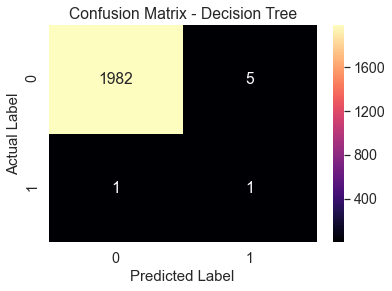

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1987
           1       0.17      0.50      0.25         2

    accuracy                           1.00      1989
   macro avg       0.58      0.75      0.62      1989
weighted avg       1.00      1.00      1.00      1989



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

X = preprocess_labelEncoder(df)
y = labelList(df.shape[0], [2459, 2460, 2450, 2430, 2437, 2438, 2448])
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

### Original data with generated data
Generated data should only be added into trianing set.

Balanced accuracy score: 1.00


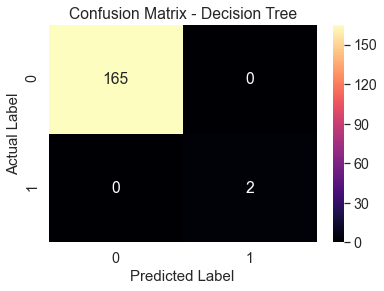

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       165
           1       1.00      1.00      1.00         2

    accuracy                           1.00       167
   macro avg       1.00      1.00      1.00       167
weighted avg       1.00      1.00      1.00       167



In [42]:
y = labelList(df.shape[0], [58, 57, 61, 211])
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.33, random_state=42)

# add generated data to the original training set
X_train_new = pd.concat([X_train, gen_data], axis=0)

X_train_new = preprocess_labelEncoder(X_train_new)

# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf = DecisionTreeClassifier()

clf.fit(X_train_new, y_train)
y_predict = clf.predict(preprocess_labelEncoder(X_test))
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

In [ ]:
# draw the tree
from sklearn import tree

plt.figure(figsize=(30, 15))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - LSASSMemoryReadAccess")
plt.savefig(r'DecisionTree\LSASSMemoryReadAccess.png', dpi=100, transparent=True)

## Save generated data

In [32]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + r'\generated_datasets' + r'\covenant_copy_smb_CreateRequest_new.json', orient='records')

dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\covenant_copy_smb_CreateRequest_new.json")
dataset.head()

,ShareName,SubjectUserName,SubjectLogonId,AccessMask,RelativeTargetName,Image,TargetFilename
0,\\*\C$,None,None,0x1,None,None,None
1,\\*\C$,pgustavo,0x4e13b2e,None,None,None,None
2,\\*\C$,None,None,None,None,None,None
3,\\*\C$,pgustavo,None,0x2,None,None,None
4,\\*\C$,None,None,0x1,None,None,None
